In [1]:
import os

import h5py
import himalaya.scoring
import numpy as np
import pandas as pd
from himalaya.backend import set_backend
from himalaya.ridge import RidgeCV
from matplotlib import pyplot as plt
import seaborn as sns
import simplstyles
from scipy.stats import zscore
from sklearn.pipeline import make_pipeline
from voxelwise_tutorials.delayer import Delayer
from voxelwise_tutorials.io import load_hdf5_array

from fmri.features import load_brain_data, load_feature

In [2]:
backend = set_backend("torch_cuda", on_error='throw')
plt.style.use('nord-light-talk')
data_dir = "../../data"

In [3]:
subject = 1
modality = "reading"
trim = 5

In [4]:
n_alphas_batch = 3
n_targets_batch = 100
n_targets_batch_refit = 50

In [5]:
number_of_delays = 4
alphas = np.logspace(-5, 20, 10)
n_iter = 25
cv = 5

In [6]:
def result_path(subject, modality, ridge_type, param_name, param_range):
    dir = f"results/brain_maps_validation_curves/{modality}/{subject}/{ridge_type}"
    os.makedirs(dir, exist_ok=True)
    path = os.path.join(dir, f"{param_name}_{param_range}.csv")
    return path

# Load features

In [ ]:
semantic_train, semantic_val = load_feature(data_dir, "english1000")

# Load brain data

In [12]:
Y_train, Y_test = load_brain_data(data_dir, subject, modality, trim)

/tmp/ipykernel_87408/2245118086.py:7: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  Y_train = np.vstack([zscore(Y_train[story][:-trim]) for story in Y_train.keys()])
/tmp/ipykernel_87408/2245118086.py:7: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  Y_train = np.vstack([zscore(Y_train[story][:-trim]) for story in Y_train.keys()])
/tmp/ipykernel_87408/2245118086.py:7: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  Y_train = np.vstack([zscore(Y_train[story][:-trim]) for story in Y_train.keys()])
/tmp/ipykernel_87408/2245118086.py:7: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic c

(3887, 81133) (612, 81133)


# Alphas

In [13]:
alpha_range = np.logspace(-5, 30, 6)
alpha_range

array([1.e-05, 1.e+02, 1.e+09, 1.e+16, 1.e+23, 1.e+30])

In [14]:
path = result_path(subject, modality, "ridge", "alpha", alpha_range)

In [ ]:
if not os.path.exists(path):
    print("File does not exist")
    delayer = Delayer(delays=range(1, number_of_delays + 1))

    solver_params = dict(
        n_targets_batch=n_targets_batch,
        n_targets_batch_refit=n_targets_batch_refit,
        n_alphas_batch=n_alphas_batch,
        score_func=himalaya.scoring.r2_score
    )
    ridge_cv = RidgeCV(alphas=alpha_range, cv=cv, solver_params=solver_params)
    pipeline = make_pipeline(
        delayer,
        ridge_cv
    )

    pipeline.fit(semantic_train, Y_train)

    score = pipeline.score(semantic_val, Y_test)

    best_alphas = pd.DataFrame(
        {
            'best_alphas': backend.to_numpy(pipeline[-1].best_alphas_),
            'score': score
        }
    )
    best_alphas.to_csv(path)
else:
    print("File exists")
    best_alphas = pd.read_csv(path)

File does not exist


/home/leo/PycharmProjects/compare_variance_residual/.venv/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/leo/PycharmProjects/compare_variance_residual/.venv/lib/python3.12/site-packages/himalaya/ridge/_random_search.py:491: UserWarning: Solving ridge is slower than solving kernel ridge when n_samples < n_features (here 3887 < 3940). Using a linear kernel in himalaya.kernel_ridge.KernelRidgeCV or himalaya.kernel_ridge.solve_kernel_ridge_cv_eigenvalues would be faster. Use warn=False to silence this warning.
  warnings.warn(
/home/leo/PycharmProjects/compare_variance_residual/.venv/lib/python3.12/site-packages/himalaya/backend/_utils.py:138: UserWarning: GPU backend torch_cuda is much faster with single precision floats (float32), got input 

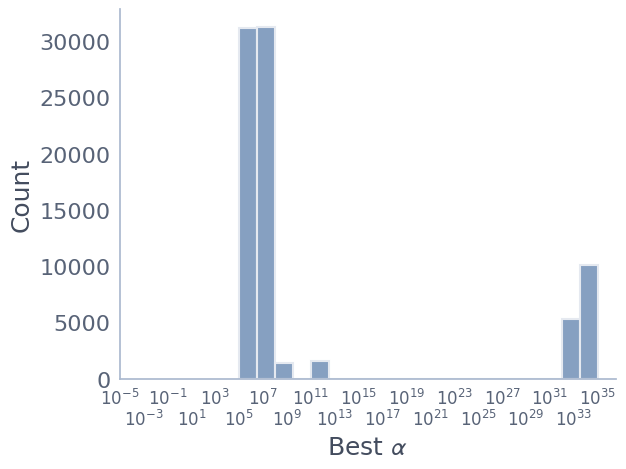

In [25]:
fig, ax = plt.subplots()
sns.histplot(best_alphas['best_alphas'], bins=20, log_scale=True, ax=ax)
plt.xlabel(r"Best $\alpha$")
plt.xticks(alpha_range)
labels_formatted = [label.get_text() if i % 2 == 0 else '\n' + label.get_text() for i, label in
                    enumerate(ax.xaxis.get_majorticklabels())]
plt.xticks(alpha_range, labels=labels_formatted, fontsize=12)
plt.show()

# CV

In [10]:
import math

cv_range = np.logspace(math.log(2.1, 10), 2, 9).astype(int)
cv_range

array([  2,   3,   5,   8,  14,  23,  38,  61, 100])

In [11]:
from sklearn.metrics import r2_score

cv_scores = []
for _cv in cv_range:
    print(_cv)
    path = result_path(subject, modality, "ridge", "cv", _cv)
    if not os.path.exists(path):
        print("File does not exist")
        delayer = Delayer(delays=range(1, number_of_delays + 1))
        solver_params = dict(
            n_targets_batch=n_targets_batch,
            n_targets_batch_refit=n_targets_batch_refit,
            score_func=himalaya.scoring.r2_score
        )
        ridge_cv = RidgeCV(alphas=alphas, cv=_cv, solver_params=solver_params)
        pipeline = make_pipeline(
            delayer,
            ridge_cv
        )
        pipeline.fit(semantic_train, Y_train)
        cv_score = pipeline[-1].cv_scores_
        prediction = pipeline.predict(semantic_val)
        prediction = backend.to_numpy(prediction)
        test_score = r2_score(Y_test, prediction, multioutput='raw_values')
        result = pd.DataFrame(
            {
                'cv_score': cv_score,
                'test_score': test_score
            }
        )
        result.to_csv(path)
    else:
        print("File exists")
        result = pd.read_csv(path)

2
File does not exist


/home/leo/PycharmProjects/compare_variance_residual/.venv/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/leo/PycharmProjects/compare_variance_residual/.venv/lib/python3.12/site-packages/himalaya/ridge/_random_search.py:491: UserWarning: Solving ridge is slower than solving kernel ridge when n_samples < n_features (here 3887 < 3940). Using a linear kernel in himalaya.kernel_ridge.KernelRidgeCV or himalaya.kernel_ridge.solve_kernel_ridge_cv_eigenvalues would be faster. Use warn=False to silence this warning.
  warnings.warn(
/home/leo/PycharmProjects/compare_variance_residual/.venv/lib/python3.12/site-packages/himalaya/backend/_utils.py:138: UserWarning: GPU backend torch_cuda is much faster with single precision floats (float32), got input 

ValueError: Input contains NaN.

Text(0.5, 0, 'CV')

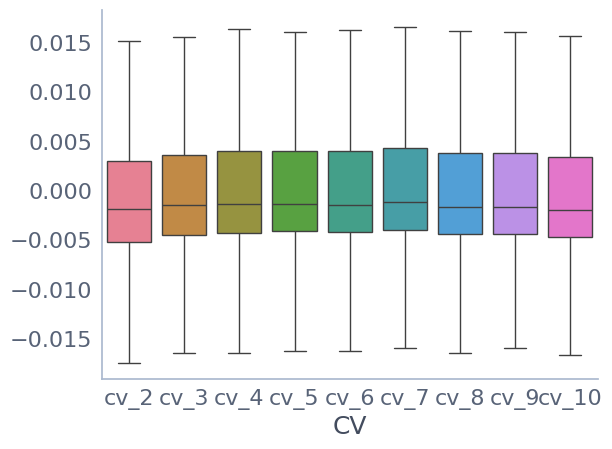

# N_iter

In [104]:
param_range = np.logspace(0, 2, 5).astype(int)
param_range

array([  1,   3,  10,  31, 100])

In [ ]:
path = result_path(subject, modality, "banded", "n_iter", param_range)